In [ ]:
# Part of the code adapted from https://github.com/pyg-team/pytorch_geometric/tree/master/examples

In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Found existing installation: torch-scatter 2.1.1+pt20cu118
Uninstalling torch-scatter-2.1.1+pt20cu118:
  Successfully uninstalled torch-scatter-2.1.1+pt20cu118
Found existing installation: torch-sparse 0.6.17+pt20cu118
Uninstalling torch-sparse-0.6.17+pt20cu118:
  Successfully uninstalled torch-sparse-0.6.17+pt20cu118
Found existing installation: torch_geometric 2.4.0
Uninstalling torch_geometric-2.4.0:
  Successfully uninstalled torch_geometric-2.4.0
Found existing installation: torch-cluster 1.6.1+pt20cu118
Uninstalling torch-cluster-1.6.1+pt20cu118:
  Successfully uninstalled torch-cluster-1.6.1+pt20cu118
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcu118/torch_scatter-2.1.1%2Bpt20cu118-cp310-cp310-linux_x86_64.whl (10.2 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/publ

In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Embedding, Linear

import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, GCNConv
from torch_geometric.nn import GATConv, HypergraphConv
from torch_geometric.nn.conv.gcn_conv import gcn_norm

dataset = MovieLens('./data', model_name='all-MiniLM-L6-v2')

In [ ]:
tensor = torch.zeros(10352,610)
for i in range(610):
    tensor[i+9742][i] = 1

In [ ]:
device = 'cuda'
data = dataset[0].to_homogeneous(dummy_values=False)

In [ ]:
import numpy as np
data.x = tensor

In [ ]:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    key = 'edge_label'
)(data)

In [ ]:
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(-1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.linear = Linear(hidden_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index).relu()

    def decode(self, z, edge_label_index):
        return self.linear((z[edge_label_index[0]] * z[edge_label_index[1]])).reshape(-1)

In [ ]:
model = GCNNet(dataset.num_features, 64, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
train_data.to(device)
val_data.to(device)
test_data.to(device)

Data(edge_index=[2, 90753], node_type=[10352], edge_type=[90753], x=[10352, 610], edge_label=[10083], edge_label_index=[2, 10083])

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model.encode(
        train_data.x,
        train_data.edge_index
    )
    out = model.decode(out, train_data.edge_label_index)
    loss = F.mse_loss(out, train_data.edge_label.float())
    loss.backward()
    optimizer.step()
    return float(loss)

In [ ]:
@torch.no_grad()
def test(data):
    model.eval()
    out = model.encode(
        data.x,
        data.edge_index
    ).clamp(min=0, max=5)
    out = model.decode(out, data.edge_label_index)
    rmse = F.mse_loss(out, data.edge_label.float()).sqrt()
    return float(rmse)

In [ ]:
import time

In [ ]:
start_time = time.time()
best_rmse = 100
loss_gcn = []
for epoch in range(1, 2102):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    loss_gcn.append(test_rmse)
    if test_rmse < best_rmse:
      best_rmse = test_rmse
    if epoch % 150 == 1:
      print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
            f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
print("time elapsed:", time.time() - start_time)
print(f"Best test rmse: {best_rmse:.4f}")

Epoch: 0001, Loss: 11.9996, Train: 3.4632, Val: 3.4632, Test: 3.4525
Epoch: 0151, Loss: 2.5741, Train: 1.5715, Val: 1.6344, Test: 1.6208
Epoch: 0301, Loss: 2.2137, Train: 1.4699, Val: 1.5513, Test: 1.5485
Epoch: 0451, Loss: 2.1091, Train: 1.4431, Val: 1.5247, Test: 1.5280
Epoch: 0601, Loss: 1.9157, Train: 1.3803, Val: 1.4620, Test: 1.4663
Epoch: 0751, Loss: 1.5137, Train: 1.2269, Val: 1.3248, Test: 1.3236
Epoch: 0901, Loss: 1.2719, Train: 1.1266, Val: 1.2324, Test: 1.2378
Epoch: 1051, Loss: 1.1592, Train: 1.0762, Val: 1.1807, Test: 1.1909
Epoch: 1201, Loss: 1.0412, Train: 1.0200, Val: 1.1259, Test: 1.1368
Epoch: 1351, Loss: 0.9345, Train: 0.9664, Val: 1.0780, Test: 1.0868
Epoch: 1501, Loss: 0.8600, Train: 0.9271, Val: 1.0388, Test: 1.0482
Epoch: 1651, Loss: 0.8127, Train: 0.9014, Val: 1.0103, Test: 1.0210
Epoch: 1801, Loss: 0.7829, Train: 0.8847, Val: 0.9891, Test: 1.0020
Epoch: 1951, Loss: 0.7637, Train: 0.8738, Val: 0.9744, Test: 0.9889
Epoch: 2101, Loss: 0.7507, Train: 0.8664, Val: 

In [ ]:
class GATNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(-1, hidden_channels)
        self.conv2 = GATConv(hidden_channels, out_channels)
        self.linear = Linear(hidden_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index).relu()

    def decode(self, z, edge_label_index):
        return self.linear((z[edge_label_index[0]] * z[edge_label_index[1]])).reshape(-1)

In [ ]:
model = GATNet(dataset.num_features, 64, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
start_time = time.time()
best_rmse = 100
loss_gat = []
for epoch in range(1, 2102):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    loss_gat.append(test_rmse)
    if test_rmse < best_rmse:
      best_rmse = test_rmse
    if epoch % 150 == 1:
      print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
            f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
print("time elapsed:", time.time() - start_time)
print(f"Best test rmse: {best_rmse:.4f}")

Epoch: 0001, Loss: 12.9266, Train: 3.5949, Val: 3.5949, Test: 3.5842
Epoch: 0151, Loss: 1.6298, Train: 1.2421, Val: 1.2839, Test: 1.2738
Epoch: 0301, Loss: 0.9166, Train: 0.9572, Val: 1.0094, Test: 1.0127
Epoch: 0451, Loss: 0.8910, Train: 0.9439, Val: 0.9984, Test: 1.0028
Epoch: 0601, Loss: 0.8728, Train: 0.9341, Val: 0.9906, Test: 0.9941
Epoch: 0751, Loss: 0.8495, Train: 0.9217, Val: 0.9785, Test: 0.9816
Epoch: 0901, Loss: 0.8412, Train: 0.9171, Val: 0.9752, Test: 0.9783
Epoch: 1051, Loss: 0.8354, Train: 0.9140, Val: 0.9726, Test: 0.9752
Epoch: 1201, Loss: 0.8296, Train: 0.9108, Val: 0.9708, Test: 0.9725
Epoch: 1351, Loss: 0.8223, Train: 0.9068, Val: 0.9680, Test: 0.9695
Epoch: 1501, Loss: 0.8119, Train: 0.9010, Val: 0.9626, Test: 0.9660
Epoch: 1651, Loss: 0.8024, Train: 0.8957, Val: 0.9571, Test: 0.9621
Epoch: 1801, Loss: 0.7938, Train: 0.8909, Val: 0.9541, Test: 0.9589
Epoch: 1951, Loss: 0.7833, Train: 0.8850, Val: 0.9516, Test: 0.9553
Epoch: 2101, Loss: 0.7740, Train: 0.8797, Val: 

In [ ]:
class SAGENet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(-1, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.linear = Linear(hidden_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index).relu()

    def decode(self, z, edge_label_index):
        return self.linear((z[edge_label_index[0]] * z[edge_label_index[1]])).reshape(-1)

In [ ]:
model = SAGENet(dataset.num_features, 64, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
start_time = time.time()
best_rmse = 100
loss_sage = []
for epoch in range(1, 2102):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    loss_sage.append(test_rmse)
    if test_rmse < best_rmse:
      best_rmse = test_rmse
    if epoch % 150 == 1:
      print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
            f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
print("time elapsed:", time.time() - start_time)
print(f"Best test rmse: {best_rmse:.4f}")

Epoch: 0001, Loss: 12.3217, Train: 3.5096, Val: 3.5096, Test: 3.4989
Epoch: 0151, Loss: 1.4154, Train: 1.1599, Val: 1.2329, Test: 1.2205
Epoch: 0301, Loss: 0.8950, Train: 0.9459, Val: 1.0363, Test: 1.0326
Epoch: 0451, Loss: 0.8540, Train: 0.9240, Val: 1.0164, Test: 1.0125
Epoch: 0601, Loss: 0.8295, Train: 0.9107, Val: 1.0038, Test: 0.9992
Epoch: 0751, Loss: 0.8182, Train: 0.9045, Val: 0.9995, Test: 0.9943
Epoch: 0901, Loss: 0.8101, Train: 0.9000, Val: 0.9986, Test: 0.9922
Epoch: 1051, Loss: 0.8008, Train: 0.8948, Val: 0.9968, Test: 0.9894
Epoch: 1201, Loss: 0.7886, Train: 0.8880, Val: 0.9865, Test: 0.9795
Epoch: 1351, Loss: 0.7737, Train: 0.8795, Val: 0.9706, Test: 0.9648
Epoch: 1501, Loss: 0.7564, Train: 0.8696, Val: 0.9645, Test: 0.9589
Epoch: 1651, Loss: 0.7412, Train: 0.8609, Val: 0.9837, Test: 0.9757
Epoch: 1801, Loss: 0.7298, Train: 0.8542, Val: 1.0140, Test: 1.0036
Epoch: 1951, Loss: 0.7212, Train: 0.8492, Val: 1.0435, Test: 1.0313
Epoch: 2101, Loss: 0.7149, Train: 0.8455, Val: 

In [ ]:
import pickle
data = {
    "loss_gcn": loss_gcn,
    "loss_gat": loss_gat,
    "loss_sage": loss_sage
}
!touch data.pkl
with open("data.pkl", "wb") as f:
    pickle.dump(data, f)

In [ ]:
data = dataset[0]

In [ ]:
# Add reverse relation for message passing
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

In [ ]:
data['user'].x = torch.arange(data['user'].num_nodes)

In [ ]:
data['user', 'movie'].edge_label = data['user', 'movie'].edge_label.float()

In [ ]:
device = 'cuda'
data.to(device)

HeteroData(
  movie={ x=[9742, 404] },
  user={
    num_nodes=610,
    x=[610]
  },
  (user, rates, movie)={
    edge_index=[2, 100836],
    edge_label=[100836]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100836] }
)

In [ ]:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

In [ ]:
# Generate the co-occurence matrix of movies<>movies:
metapath = [('movie', 'rev_rates', 'user'), ('user', 'rates', 'movie')]
train_data = T.AddMetaPaths(metapaths=[metapath])(train_data)

# Apply normalization to filter the metapath:
_, edge_weight = gcn_norm(
    train_data['movie', 'movie'].edge_index,
    num_nodes=train_data['movie'].num_nodes,
    add_self_loops=False,
)
edge_index = train_data['movie', 'movie'].edge_index[:, edge_weight > 0.002]

train_data['movie', 'metapath_0', 'movie'].edge_index = edge_index
val_data['movie', 'metapath_0', 'movie'].edge_index = edge_index
test_data['movie', 'metapath_0', 'movie'].edge_index = edge_index

In [ ]:
class MovieGNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = GCNConv(-1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.lin(x)

In [ ]:
class UserGNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(-1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        user_x = self.conv1(x_dict, edge_index_dict).relu()

        user_x = self.conv2(user_x, edge_index_dict).relu()

        user_x = self.conv3(user_x, edge_index_dict).relu()

        return self.lin(user_x)

In [ ]:
class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_src, z_dst, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_src[row], z_dst[col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, num_users, hidden_channels, out_channels):
        super().__init__()
        self.user_emb = Embedding(num_users, hidden_channels)
        self.user_encoder = UserGNNEncoder(hidden_channels, out_channels)
        self.movie_encoder = MovieGNNEncoder(hidden_channels, out_channels)
        self.decoder = EdgeDecoder(out_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = {}
        x_dict['user'] = self.user_emb(x_dict['user'])
        z_dict['user'] = self.user_encoder(x_dict['movie'],
            edge_index_dict[('movie', 'rev_rates', 'user')])
        z_dict['movie'] = self.movie_encoder(
            x_dict['movie'],
            edge_index_dict[('movie', 'metapath_0', 'movie')],
        )
        return self.decoder(z_dict['user'], z_dict['movie'], edge_label_index)

In [ ]:
model = Model(data['user'].num_nodes, hidden_channels=64, out_channels=64)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(
        train_data.x_dict,
        train_data.edge_index_dict,
        train_data['user', 'movie'].edge_label_index,
    )
    loss = F.mse_loss(out, train_data['user', 'movie'].edge_label.float())
    loss.backward()
    optimizer.step()
    return float(loss)

In [ ]:
@torch.no_grad()
def test(data):
    model.eval()
    out = model(
        data.x_dict,
        data.edge_index_dict,
        data['user', 'movie'].edge_label_index,
    ).clamp(min=0, max=5)
    rmse = F.mse_loss(out, data['user', 'movie'].edge_label.float()).sqrt()
    return float(rmse)

In [ ]:
import time

In [ ]:
start_time = time.time()
best_rmse = 100
loss_gcn_2 = []
best_rmse = 100
for epoch in range(1, 2102):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    loss_gcn_2.append(test_rmse)
    if test_rmse < best_rmse:
      best_rmse = test_rmse
    if epoch % 150 == 1:
      print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
            f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
print("time elapsed:", time.time() - start_time)
print(f"Best test rmse: {best_rmse:.4f}")

Epoch: 0001, Loss: 12.8452, Train: 3.5157, Val: 3.5192, Test: 3.5085
Epoch: 0151, Loss: 1.3640, Train: 1.1644, Val: 1.1693, Test: 1.1720
Epoch: 0301, Loss: 1.0236, Train: 1.0109, Val: 1.0212, Test: 1.0261
Epoch: 0451, Loss: 0.9191, Train: 0.9579, Val: 0.9773, Test: 0.9778
Epoch: 0601, Loss: 0.8728, Train: 0.9341, Val: 0.9603, Test: 0.9609
Epoch: 0751, Loss: 0.8446, Train: 0.9189, Val: 0.9499, Test: 0.9525
Epoch: 0901, Loss: 0.8259, Train: 0.9090, Val: 0.9435, Test: 0.9478
Epoch: 1051, Loss: 0.8110, Train: 0.9005, Val: 0.9381, Test: 0.9434
Epoch: 1201, Loss: 0.8001, Train: 0.8944, Val: 0.9350, Test: 0.9412
Epoch: 1351, Loss: 0.7924, Train: 0.8905, Val: 0.9340, Test: 0.9409
Epoch: 1501, Loss: 0.7836, Train: 0.8851, Val: 0.9314, Test: 0.9384
Epoch: 1651, Loss: 0.7776, Train: 0.8817, Val: 0.9305, Test: 0.9378
Epoch: 1801, Loss: 0.7720, Train: 0.8787, Val: 0.9296, Test: 0.9375
Epoch: 1951, Loss: 0.7674, Train: 0.8763, Val: 0.9290, Test: 0.9372
Epoch: 2101, Loss: 0.7648, Train: 0.8733, Val: 

In [ ]:
'''
The following code uses GraphSage

'''

In [ ]:
class SageMovieGNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = SAGEConv(-1, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.lin(x)

In [ ]:
class SageUserGNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)
        self.conv3 = SAGEConv((-1, -1), hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        movie_x = self.conv1(
            x_dict['movie'],
            edge_index_dict[('movie', 'metapath_0', 'movie')],
        ).relu()

        user_x = self.conv2(
            (x_dict['movie'], x_dict['user']),
            edge_index_dict[('movie', 'rev_rates', 'user')],
        ).relu()

        user_x = self.conv3(
            (movie_x, user_x),
            edge_index_dict[('movie', 'rev_rates', 'user')],
        ).relu()

        return self.lin(user_x)

In [ ]:
class SageEdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_src, z_dst, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_src[row], z_dst[col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

In [ ]:
class SageModel(torch.nn.Module):
    def __init__(self, num_users, hidden_channels, out_channels):
        super().__init__()
        self.user_emb = Embedding(num_users, hidden_channels)
        self.user_encoder = SageUserGNNEncoder(hidden_channels, out_channels)
        self.movie_encoder = SageMovieGNNEncoder(hidden_channels, out_channels)
        self.decoder = SageEdgeDecoder(out_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = {}
        x_dict['user'] = self.user_emb(x_dict['user'])
        z_dict['user'] = self.user_encoder(x_dict, edge_index_dict)
        z_dict['movie'] = self.movie_encoder(
            x_dict['movie'],
            edge_index_dict[('movie', 'metapath_0', 'movie')],
        )
        return self.decoder(z_dict['user'], z_dict['movie'], edge_label_index)

In [ ]:
model = SageModel(data['user'].num_nodes, hidden_channels=64, out_channels=64)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
start_time = time.time()
best_rmse = 100
loss_sage_2 = []
best_rmse = 100
for epoch in range(1, 2102):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    loss_sage_2.append(test_rmse)
    if test_rmse < best_rmse:
      best_rmse = test_rmse
    if epoch % 150 == 1:
      print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
            f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
print("time elapsed:", time.time() - start_time)
print(f"Best test rmse: {best_rmse:.4f}")

Epoch: 0001, Loss: 13.2709, Train: 3.5232, Val: 3.5211, Test: 3.5274
Epoch: 0151, Loss: 1.0372, Train: 1.0178, Val: 1.0272, Test: 1.0213
Epoch: 0301, Loss: 0.9119, Train: 0.9547, Val: 0.9699, Test: 0.9616
Epoch: 0451, Loss: 0.8437, Train: 0.9182, Val: 0.9414, Test: 0.9310
Epoch: 0601, Loss: 0.7642, Train: 0.8739, Val: 0.9172, Test: 0.9117
Epoch: 0751, Loss: 0.7199, Train: 0.8482, Val: 0.9106, Test: 0.9101
Epoch: 0901, Loss: 0.6944, Train: 0.8331, Val: 0.9101, Test: 0.9110
Epoch: 1051, Loss: 0.6763, Train: 0.8223, Val: 0.9115, Test: 0.9123
Epoch: 1201, Loss: 0.6651, Train: 0.8154, Val: 0.9127, Test: 0.9133
Epoch: 1351, Loss: 0.6585, Train: 0.8115, Val: 0.9165, Test: 0.9177
Epoch: 1501, Loss: 0.6532, Train: 0.8082, Val: 0.9176, Test: 0.9197
Epoch: 1651, Loss: 0.6496, Train: 0.8058, Val: 0.9194, Test: 0.9217
Epoch: 1801, Loss: 0.6454, Train: 0.8031, Val: 0.9194, Test: 0.9218
Epoch: 1951, Loss: 0.6412, Train: 0.8007, Val: 0.9187, Test: 0.9212
Epoch: 2101, Loss: 0.6380, Train: 0.7988, Val: 

In [ ]:
'''
The following uses graph attention networks

'''

In [ ]:
class AttentionMovieGNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = GATConv(-1, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.lin(x)

In [ ]:
class AttentionUserGNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels)
        self.conv2 = GATConv((-1, -1), hidden_channels)
        self.conv3 = GATConv((-1, -1), hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        movie_x = self.conv1(
            x_dict['movie'],
            edge_index_dict[('movie', 'metapath_0', 'movie')],
        ).relu()

        user_x = self.conv2(
            (x_dict['movie'], x_dict['user']),
            edge_index_dict[('movie', 'rev_rates', 'user')],
        ).relu()

        user_x = self.conv3(
            (movie_x, user_x),
            edge_index_dict[('movie', 'rev_rates', 'user')],
        ).relu()

        return self.lin(user_x)

In [ ]:
class AttentionEdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_src, z_dst, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_src[row], z_dst[col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

In [ ]:
class AttentionModel(torch.nn.Module):
    def __init__(self, num_users, hidden_channels, out_channels):
        super().__init__()
        self.user_emb = Embedding(num_users, hidden_channels)
        self.user_encoder = AttentionUserGNNEncoder(hidden_channels, out_channels)
        self.movie_encoder = AttentionMovieGNNEncoder(hidden_channels, out_channels)
        self.decoder = SageEdgeDecoder(out_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = {}
        x_dict['user'] = self.user_emb(x_dict['user'])
        z_dict['user'] = self.user_encoder(x_dict, edge_index_dict)
        z_dict['movie'] = self.movie_encoder(
            x_dict['movie'],
            edge_index_dict[('movie', 'metapath_0', 'movie')],
        )
        return self.decoder(z_dict['user'], z_dict['movie'], edge_label_index)

In [ ]:
model = AttentionModel(data['user'].num_nodes, hidden_channels=64, out_channels=64)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
start_time = time.time()
best_rmse = 100
loss_gat_2 = []
best_rmse = 100
for epoch in range(1, 2102):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    loss_gat_2.append(test_rmse)
    if test_rmse < best_rmse:
      best_rmse = test_rmse
    if epoch % 150 == 1:
      print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
            f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
print("time elapsed:", time.time() - start_time)
print(f"Best test rmse: {best_rmse:.4f}")

Epoch: 0001, Loss: 12.8010, Train: 3.5232, Val: 3.5211, Test: 3.5274
Epoch: 0151, Loss: 1.1870, Train: 1.0892, Val: 1.0980, Test: 1.0865
Epoch: 0301, Loss: 1.1028, Train: 1.0499, Val: 1.0615, Test: 1.0506
Epoch: 0451, Loss: 0.9994, Train: 0.9995, Val: 1.0116, Test: 1.0042
Epoch: 0601, Loss: 0.9305, Train: 0.9644, Val: 0.9817, Test: 0.9760
Epoch: 0751, Loss: 0.8776, Train: 0.9366, Val: 0.9628, Test: 0.9557
Epoch: 0901, Loss: 0.8369, Train: 0.9147, Val: 0.9507, Test: 0.9426
Epoch: 1051, Loss: 0.8045, Train: 0.8969, Val: 0.9425, Test: 0.9369
Epoch: 1201, Loss: 0.7814, Train: 0.8840, Val: 0.9361, Test: 0.9338
Epoch: 1351, Loss: 0.7636, Train: 0.8738, Val: 0.9324, Test: 0.9330
Epoch: 1501, Loss: 0.7496, Train: 0.8658, Val: 0.9309, Test: 0.9334
Epoch: 1651, Loss: 0.7391, Train: 0.8597, Val: 0.9307, Test: 0.9336
Epoch: 1801, Loss: 0.7294, Train: 0.8541, Val: 0.9296, Test: 0.9337
Epoch: 1951, Loss: 0.7225, Train: 0.8503, Val: 0.9300, Test: 0.9359
Epoch: 2101, Loss: 0.7152, Train: 0.8457, Val: 

In [ ]:
from torch_geometric.nn import to_hetero

In [ ]:
data = dataset[0].to(device)

# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)


In [ ]:
# Generate the co-occurence matrix of movies<>movies:
metapath = [('movie', 'rev_rates', 'user'), ('user', 'rates', 'movie')]
train_data = T.AddMetaPaths(metapaths=[metapath])(train_data)

# Apply normalization to filter the metapath:
_, edge_weight = gcn_norm(
    train_data['movie', 'movie'].edge_index,
    num_nodes=train_data['movie'].num_nodes,
    add_self_loops=False,
)
edge_index = train_data['movie', 'movie'].edge_index[:, edge_weight > 0.002]

train_data['movie', 'metapath_0', 'movie'].edge_index = edge_index
val_data['movie', 'metapath_0', 'movie'].edge_index = edge_index
test_data['movie', 'metapath_0', 'movie'].edge_index = edge_index

In [ ]:
class HeteroGNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

In [ ]:
class HeteroEdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

In [ ]:
class HeteroModel(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = HeteroGNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = HeteroEdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [ ]:
model = HeteroModel(hidden_channels=64).to(device)
# Due to lazy initialization, we need to run one model step so the number
# of parameters can be inferred:
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
start_time = time.time()
best_rmse = 100
loss_het_2 = []
best_rmse = 100
for epoch in range(1, 2102):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    loss_het_2.append(test_rmse)
    if test_rmse < best_rmse:
      best_rmse = test_rmse
    if epoch % 150 == 1:
      print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
            f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
print("time elapsed:", time.time() - start_time)
print(f"Best test rmse: {best_rmse:.4f}")

Epoch: 0001, Loss: 12.1670, Train: 3.4772, Val: 3.4749, Test: 3.4911
Epoch: 0151, Loss: 1.1013, Train: 1.0490, Val: 1.0714, Test: 1.0417
Epoch: 0301, Loss: 0.9283, Train: 0.9629, Val: 0.9905, Test: 0.9644
Epoch: 0451, Loss: 0.8189, Train: 0.9047, Val: 0.9356, Test: 0.9175
Epoch: 0601, Loss: 0.7719, Train: 0.8784, Val: 0.9226, Test: 0.9098
Epoch: 0751, Loss: 0.7288, Train: 0.8535, Val: 0.9122, Test: 0.9039
Epoch: 0901, Loss: 0.6858, Train: 0.8280, Val: 0.9082, Test: 0.9021
Epoch: 1051, Loss: 0.6639, Train: 0.8147, Val: 0.9127, Test: 0.9084
Epoch: 1201, Loss: 0.6531, Train: 0.8081, Val: 0.9138, Test: 0.9116
Epoch: 1351, Loss: 0.6469, Train: 0.8042, Val: 0.9170, Test: 0.9166
Epoch: 1501, Loss: 0.6422, Train: 0.8014, Val: 0.9191, Test: 0.9194
Epoch: 1651, Loss: 0.6393, Train: 0.7994, Val: 0.9220, Test: 0.9225
Epoch: 1801, Loss: 0.6366, Train: 0.7978, Val: 0.9227, Test: 0.9240
Epoch: 1951, Loss: 0.6346, Train: 0.7966, Val: 0.9245, Test: 0.9262
Epoch: 2101, Loss: 0.6330, Train: 0.7955, Val: 

In [ ]:
data = {
    "loss_gcn": loss_gcn,
    "loss_gat": loss_gat,
    "loss_sage": loss_sage,
    "loss_gcn_2": loss_gcn_2,
    "loss_gat_2": loss_gat_2,
    "loss_sage_2": loss_sage_2,
    "loss_het": loss_het_2
}
!touch data.pkl
with open("data.pkl", "wb") as f:
    pickle.dump(data, f)

In [ ]:
data = pickle.load(open('data.pkl','rb'))

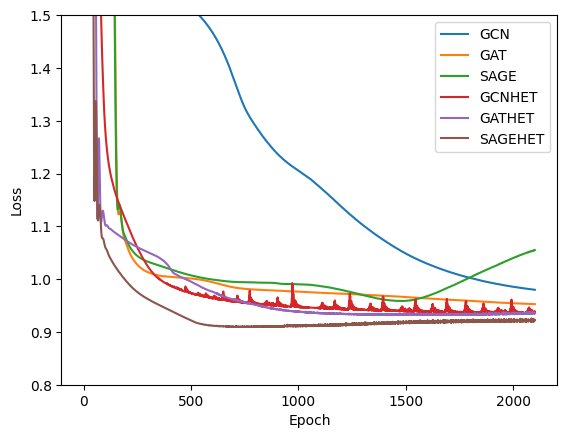

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

x = np.arange(1, len(data['loss_gcn']) + 1)
y_gcn = np.array(data['loss_gcn'])
y_gat = np.array(data['loss_gat'])
y_sage = np.array(data['loss_sage'])
y_gcn_2 = np.array(data['loss_gcn_2'])
y_gat_2 = np.array(data['loss_gat_2'])
y_sage_2 = np.array(data['loss_sage_2'])
# y_het_2 = np.array(data['loss_het'])

ax.plot(x, y_gcn, label="GCN")
ax.plot(x, y_gat, label="GAT")
ax.plot(x, y_sage, label="SAGE")
ax.plot(x, y_gcn_2, label="GCNHET")
ax.plot(x, y_gat_2, label="GATHET")
ax.plot(x, y_sage_2, label="SAGEHET")
# ax.plot(x, y_het_2, label="HETGNN")
ax.set_ylim(0.8, 1.5)

ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

plt.savefig("loss_curve.pdf")